k:  0  mean: 3.3  x: 0
k:  0  mean: 3.0  x: 11
k:  0  mean: 3.4  x: 1
k:  0  mean: 3.6  x: 2
k:  0  mean: 3.1  x: 6
k:  0  mean: 3.4  x: 7
k:  0  mean: 3.4  x: 8
k:  0  mean: 4.0  x: 10
k:  0  mean: 3.3  x: 4
k:  0  mean: 3.7  x: 5
k:  0  mean: 4.0  x: 3
k:  0  mean: 3.3  x: 9
k:  1  mean: 5.0  x: 0
k:  1  mean: 4.9  x: 11
k:  1  mean: 5.6  x: 1
k:  1  mean: 4.3  x: 2
k:  1  mean: 4.9  x: 6
k:  1  mean: 5.0  x: 7
k:  1  mean: 5.1  x: 8
k:  1  mean: 4.8  x: 4
k:  1  mean: 4.6  x: 5
k:  1  mean: 5.4  x: 3
k:  1  mean: 5.0  x: 9
k:  2  mean: 6.5  x: 0
k:  2  mean: 6.8  x: 11
k:  2  mean: 6.2  x: 2
k:  2  mean: 5.5  x: 6
k:  2  mean: 6.5  x: 7
k:  2  mean: 6.0  x: 8
k:  2  mean: 6.2  x: 4
k:  2  mean: 5.5  x: 5
k:  2  mean: 6.1  x: 3
k:  2  mean: 6.8  x: 9
Seed: [10, 1, 11]   max: 6.8
Size of cascade:
5.8 5.2

Last Resulting Cascade:
[1, 5, 4, 3, 2, 11]
[1, 5, 4, 2, 3]
ig
8.901
nx
8.903
ig
12.772666666666666
nx
12.899333333333333
ig
12.9185
nx
12.992
ig
13.0095
nx
13.03525


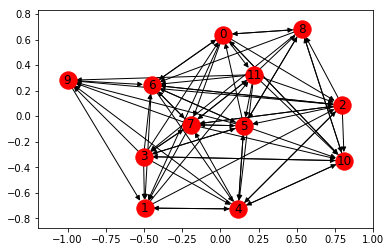

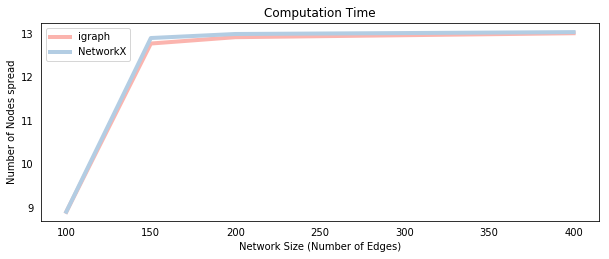

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from igraph import *
import networkx as nx
from random import uniform, seed
import numpy as np
import pandas as pd
import time
def IC(graph_object,S,p,mc):
    """
    Inputs: graph_object: 4 possible network representations 
                - igraph object
                - Networkx object
                - E x 2 Pandas dataframe of directed edges. Columns: ['source','target']
                - dictionary with key=source node & values=out-neighbors
            S:  List of seed nodes
            p:  Disease propagation probability
            mc: Number of Monte-Carlo simulations,
    Output: Average number of nodes influenced by seed nodes in S
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:
            targets=[]           
            # 1. Find out-neighbors for each newly active node
            if isinstance(graph_object, Graph):
                targets = propagate_ig(graph_object,p,new_active)
            elif isinstance(graph_object, nx.DiGraph):
                targets = propagate_nx(graph_object,p,new_active)
    
            # 2. Determine newly activated neighbors (set seed and sort for consistency)
            np.random.seed(i)
            success = np.random.uniform(0,1,len(targets)) < p
            new_ones = list(np.extract(success, sorted(targets)))
            
            # 3. Find newly activated nodes and add to the set of activated nodes
            new_active = list(set(new_ones) - set(A))
            #print("new_active:",new_active)
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread),A)
def propagate_ig(g,p,new_active):
    
    targets = []
    peer={}
    temp=[]
    f=lambda x:x not in new_active 
    for node in new_active:
        temp=g.neighbors(node,mode="out");
        
        peer[node] = list(filter(f,temp))
        if(len(peer.get(node,[]))!=0):
            targets.append(peer[node][math.floor(np.random.uniform(0,1)*len(peer[node]))])
    return(targets)

def propagate_nx(g,p,new_active):
    targets = []
    peer={}
    temp=[]
    f=lambda x:x not in new_active  
    for node in new_active:
        temp=g.neighbors(node);
        
        peer[node] = list(filter(f,temp))
        if(len(peer.get(node,[]))!=0):
            targets.append(peer[node][math.floor(np.random.uniform(0,1)*len(peer[node]))])
    return(targets)
def make_graph(nodes,edges):
    
    # Generate igraph object
    G = Graph.Erdos_Renyi(n=nodes,m=edges,directed=True)

    # Transform into NetworkX object
    g = nx.DiGraph(G.get_edgelist())


    return(G, g)

# Create Graphs
G, g = make_graph(12,72)
nx.draw_networkx(g);
Seed=[];
mean=0;
Active=[];
max_mean=0;
max_x=-1;
k=3;
for i in range(k):
    b=False;
    max_mean=0;
    max_x=-1;
    for x in g.nodes():
        
        if x not in Seed:
            b=True;
            Seed.append(x);
            mean,Active=IC(g,Seed,p=0.7,mc=10);
            if mean>max_mean:
                max_mean=mean;
                max_x=x;
            Seed.remove(x);
            print("k: ",i," mean:",mean," x:",x);
    if(b):        
        Seed.append(max_x);
print("Seed:",Seed,"  max:",max_mean);


# Choose arbitrary seed set
S = [1,5,4]

# Run algorithms
output_ig, A_ig = IC(G,S,p=0.7,mc=10)
output_nx, A_nx = IC(g,S,p=0.7,mc=10)

# Print size of cascade
print("Size of cascade:")
print(output_ig,output_nx)

# Print last activated set of nodes
print("\nLast Resulting Cascade:")
print(A_ig); print(A_nx);
# Simulate the processes for different network sizes
e_size = [100,150,200,400]
ig_time, nx_time, df_time, di_time = [], [], [], []
output1igfig=[]
output1nxfig=[]
output1difig=[]
output1dffig=[]
for edges in e_size:
    
    G, g = make_graph(50,edges)
    print("ig")
    start_time = time.time() 
    output1ig,Aig = IC(G,S,p=0.8,mc=10*edges)
    ig_time.append(time.time() - start_time)
    print(output1ig)
    output1igfig.append(output1ig);
    start_time = time.time()
    
    print("nx")
    output1nx,Anx = IC(g,S,p=0.8,mc=10*edges)
    nx_time.append(time.time() - start_time)
    output1nxfig.append(output1nx);
    print(output1nx)
# Plot all methods
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)
ax.plot(e_size, output1igfig, label="igraph", color="#FBB4AE",lw=4)
ax.plot(e_size, output1nxfig, label="NetworkX",color="#B3CDE3",lw=4)
ax.legend(loc = 2)
plt.ylabel('Number of Nodes spread')
plt.xlabel('Network Size (Number of Edges)')
plt.title('Computation Time')
plt.tick_params(bottom = False, left = False)
plt.show()